In [206]:
from openai import OpenAI
import re

client = OpenAI(
    api_key = "c8a7e43e-cce1-4d61-af75-de350b7e5731",
    base_url = "https://ark.cn-beijing.volces.com/api/v3",
)

In [207]:
import argparse
import pdb

from builder import build
from util import DEFAULTS

In [208]:
# print("----- standard request -----")
# completion = client.chat.completions.create(
#     model = "deepseek-r1-250120",  # your model endpoint ID
#     messages = [
#         {
#             "role": "user", 
#             "content": "1+1=?"
#         },
#     ],
# )

In [209]:
# print("----- Reasoning content -----")
# print(completion.choices[0].message.reasoning_content)

In [210]:
#print("----- Content -----")
#print(completion.choices[0].message.content)

In [211]:
filename = '..\grammar_example_wo-tri.txt'
with open(filename) as file:
        grammer_example = [line for line in file]
grammer_example = ''.join(grammer_example)

In [212]:
quest = '根据文档中的GMBL的语法和示例，使用GMBL语法，生成一道直角三角形长度计算相关的简单几何题的代码。请确保每个点在使用前都已经定义过，确保符合示例的GMBL语法，确保每一句语句都写在同一行，确保GMBL输入的角度是弧度制，确保没有直接定义数值对象。'

In [213]:
messages = [{
    "role": "user", 
    "content": grammer_example + '\n\n' + quest
    }]

In [214]:
response = client.chat.completions.create(
    # 替换 <Model> 为模型的Model ID
    model="deepseek-r1-250120",
    messages=messages,
    stream=True,
)
reasoning_content = ""
content = ""

for chunk in response:
    if hasattr(chunk.choices[0].delta, 'reasoning_content') and chunk.choices[0].delta.reasoning_content:
        reasoning_content += chunk.choices[0].delta.reasoning_content
        print(chunk.choices[0].delta.reasoning_content, end="")
    else:
        content += chunk.choices[0].delta.content
        print(chunk.choices[0].delta.content, end="")

好的，我需要根据用户的要求，用GMBL语法生成一道关于直角三角形长度计算的简单几何题。首先，我得回忆一下GMBL的语法规则，确保每一步都正确，并且符合用户提供的文档中的示例。

首先，题目是关于直角三角形的边长计算。通常，直角三角形的问题可能涉及勾股定理或者利用面积、垂足等概念。我需要构造一个直角三角形，比如直角顶点在C，然后其他两个顶点是A和B。这样，AC和BC是直角边，AB是斜边。

接下来，我需要用GMBL的param、define、assert和eval语句来定义点和条件，并验证某个结论。根据示例，点需要先通过param或define来定义，确保在使用前已存在。

可能的步骤：
1. 定义三个点A、B、C作为直角三角形的顶点，其中C是直角顶点。
2. 确保AC和BC垂直，即直线AC和BC的斜率乘积为-1，但在GMBL中应该用predicate perp来判断。
3. 计算AB的长度，然后通过其他方式（比如中点或垂足）来构造某个点，最后验证某个长度关系。

或者，可以设定AC和BC的长度，然后验证AB的长度是否符合勾股定理。但用户提到不能直接定义数值对象，所以可能需要通过其他几何构造来间接表达。

例如，可以参数化点A和B，然后定义C为A到直线BC的垂足，或者利用foot函数来得到垂足。然后通过断言两线段垂直，再验证AB的平方等于AC平方加BC平方。

但GMBL中的eval可能需要用具体的predicate，比如cong（线段长度相等）或者通过计算距离的表达式。例如，使用(= (add (pow (dist A C) 2) (pow (dist B C) 2)) (pow (dist A B) 2)) 来验证勾股定理。

不过，用户希望的问题要简单，可能直接定义点，断言垂直，然后验证某个距离关系。比如，设定AC=3， BC=4，AB应该等于5。但根据文档中的示例，不能直接使用数值参数，需要用其他几何构造来间接设定长度。

或者，可以通过参数化点A、B、C，并断言AC和BC垂直，同时设定AC和BC的长度相等，然后验证AB的长度是否符合sqrt(2)*AC。但如何设定长度呢？可能需要用assert来断言距离的关系。

例如：

(param A point)
(param B point)
(param C point)
(assert (perp (line 

In [215]:
print(content)
content



```GMBL
(param A point)
(param B point)
(param C point)
(assert (perp (line A C) (line B C)))
(assert (= (dist A C) 3))
(assert (= (dist B C) 4))
(eval (= (dist A B) 5))
```


'\n\n```GMBL\n(param A point)\n(param B point)\n(param C point)\n(assert (perp (line A C) (line B C)))\n(assert (= (dist A C) 3))\n(assert (= (dist B C) 4))\n(eval (= (dist A B) 5))\n```'

In [216]:
re_find = re.finditer('```', content)
inds = []
for ind in re_find:
    inds += [ind.span()]

lines = content[inds[0][1] : inds[1][0]]
lines = lines.splitlines()[1:]

print(lines)

['(param A point)', '(param B point)', '(param C point)', '(assert (perp (line A C) (line B C)))', '(assert (= (dist A C) 3))', '(assert (= (dist B C) 4))', '(eval (= (dist A B) 5))']


In [217]:
inds

[(2, 5), (172, 175)]

In [218]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def')


args = parser.parse_args()
args = vars(args)

In [219]:
args['n_tries'] = 10
args['eps'] = 3e-4

args['lines'] = lines
lines

['(param A point)',
 '(param B point)',
 '(param C point)',
 '(assert (perp (line A C) (line B C)))',
 '(assert (= (dist A C) 3))',
 '(assert (= (dist B C) 4))',
 '(eval (= (dist A B) 5))']

Processing instructions...:   0%|          | 0/7 [00:00<?, ?it/s]

INPUT INSTRUCTIONS:
parameterize A coords
parameterize B coords
parameterize C coords
assert (perp (connecting A C) (connecting B C))
assert (eq-n (dist A C) 3.0)
assert (eq-n (dist B C) 4.0)
eval (eq-n (dist A B) 5.0)


Sampling initializations...: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


[     0]  11.205143332345 ||   0.100000
======== Print losses ==========
-- Losses --
  perp_(connecting A C)_(connecting B C)             0.3636031690
  eq-n_(dist A C)_3.0                                4.6997291867
  eq-n_(dist B C)_4.0                                6.1418104022
  points                                             0.0000005744
  distinct                                           0.0000000000
-- Goals --
  eq-n_(dist A B)_5.0                                13.3778834086
-- NDGs --


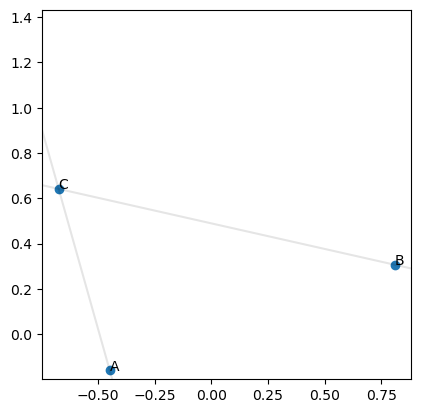

======== Print losses ==========
-- Losses --
  perp_(connecting A C)_(connecting B C)             0.0000135115
  eq-n_(dist A C)_3.0                                0.0001858799
  eq-n_(dist B C)_4.0                                0.0000000194
  points                                             0.0000057103
  distinct                                           0.0000000000
-- Goals --
  eq-n_(dist A B)_5.0                                0.0000572930
-- NDGs --


Found 1 models


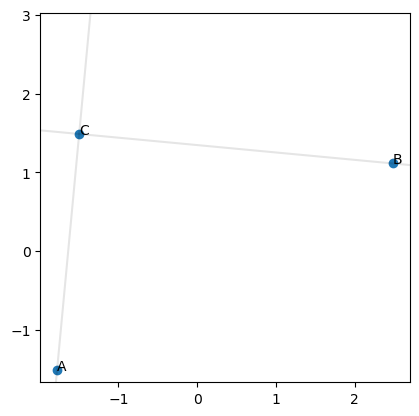

In [220]:
res = build(args)

In [221]:
for item in res[0]:
    print(item)

print('\n##############################################')

for item in res[1][0]:
    print(item)

(param A point)
(param B point)
(param C point)
(assert (perp (line A C) (line B C)))
(assert (= (dist A C) 3))
(assert (= (dist B C) 4))
(eval (= (dist A B) 5))

##############################################
{<primitives.Point object at 0x000002149F693160>: TfPoint(x=-1.7775809818446415, y=-1.5119320814029706), <primitives.Point object at 0x00000214AAFB6A30>: TfPoint(x=2.485904232953325, y=1.1145566873320447), <primitives.Point object at 0x00000214AAFB61F0>: TfPoint(x=-1.4967098869420183, y=1.4885845201691437)}
{}
{}
[]
[]
[]
[LineNF(n=TfPoint(x=-0.9956473941645084, y=0.09320014213199415), r=1.628931587609327), LineNF(n=TfPoint(x=0.09350370887239347, y=0.9956189313322173), r=1.342115003633425)]
[]
{}
{'eq-n_(dist A B)_5.0': 5.729299466983038e-05}


In [222]:
for obj_name, obj in res[1][0].named_points.items():
    print(obj_name)
    print(obj)
    (x, y) = obj

for obj_name, obj in res[1][0].named_lines.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj
    # slope = y/x, intercept = r

for obj_name, obj in res[1][0].named_circles.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj

A
(coords -1.777581 -1.511932)
B
(coords 2.485904 1.114557)
C
(coords -1.496710 1.488585)
